## Finding and working with contours with matplotlib
This is an example of how to extract and use information from contours plotted with `matplotlib`.

It is configured to work with the bathymetric data from BSOSE, on `oahu`. The basic approach is generalizable to any data.

In [6]:
import xarray as xr
import numpy as np
import utils.geo as geo
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [7]:
rootdir = '/local/data/bSOSE/iter133NEW/'
filename = 'grid.nc'
ds = xr.open_dataset(rootdir+filename)

In [8]:
# Specify the contour value that you want to work with
# Here, I choose the 1000m isobath
cval = 1000

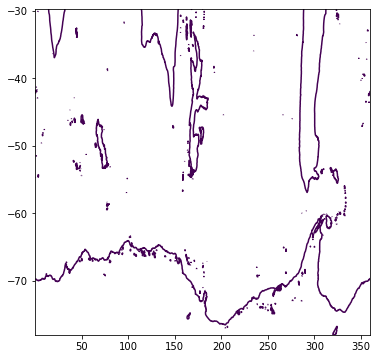

In [9]:
# Plot this contour
fig,ax=plt.subplots(figsize=(6,6))
cs = ax.contour(ds['XC'],ds['YC'],ds['Depth'],levels=[1000])

### Isolate a specific contour

In [16]:
# Specify a "startpoint" that will pick up the contour that you're interested in
# Here, I want the long contour close to the Antarctic continent, so I pick out the contour near 160E 70S
startpoint=[160,-70]

In [17]:
# Find the contour nearest to this start point
initdistance = 1e5
for i in cs.collections[0].get_paths():
    v = i.vertices
    dlon = v[:,0]-startpoint[0]
    dlat = v[:,1]-startpoint[1]
    xdistance, ydistance = geo._degrees_to_meters(dlon,dlat,v[:,0],v[:,1])
    distance = (xdistance*1e-3)**2 + (ydistance*1e-3)**2
    minimum = np.min(distance)
    if minimum < initdistance:
        initdistance = minimum
        minpointnow = np.argmin(distance)
        vnow = v
        inow = i

The details of the contour, e.g. its lat and lon, are now stored in `inow`. The vertices of each point on the contour are in `vnow`. The index, along this contour, of the point closest to your starting point is `minpointnow`.

In [20]:
inow, vnow, minpointnow

(Path(array([[ 8.33333358e-02, -6.96790223e+01],
        [ 2.50000000e-01, -6.96907215e+01],
        [ 4.16666687e-01, -6.97025863e+01],
        ...,
        [ 3.59638896e+02, -6.96762695e+01],
        [ 3.59750000e+02, -6.96577253e+01],
        [ 3.59916687e+02, -6.96569468e+01]]), None),
 array([[ 8.33333358e-02, -6.96790223e+01],
        [ 2.50000000e-01, -6.96907215e+01],
        [ 4.16666687e-01, -6.97025863e+01],
        ...,
        [ 3.59638896e+02, -6.96762695e+01],
        [ 3.59750000e+02, -6.96577253e+01],
        [ 3.59916687e+02, -6.96569468e+01]]),
 1423)

### Identify points equally spaced along contour, starting from the specified start point

In [61]:
# Calculate the distance from the each point to its next point on the contour
dlon = np.diff(vnow[:,0])
dlat = np.diff(vnow[:,1])
lonm = 0.5*(vnow[1:,0]+vnow[:-1,0])
latm = 0.5*(vnow[1:,1]+vnow[:-1,1])
dx, dy = geo._degrees_to_meters(dlon,dlat,lonm,latm)
# Determine distances along the contour
distance = np.sqrt(dx**2+dy**2)*1e-3
cumdistance = np.cumsum(distance)

In [69]:
separation = 500 # Desired spacing along (in km)

# If you want to get evenly spaced points along the whole contour:
istart = 0
cumdistanceadj = cumdistance-cumdistance[istart]
minima, = argrelextrema(cumdistance[istart:]%separation,np.less)
minima = np.append(istart,minima)+istart
# Get the lat and lon of points along contour
initlon = vnow[minima,0]
initlat = vnow[minima,1]

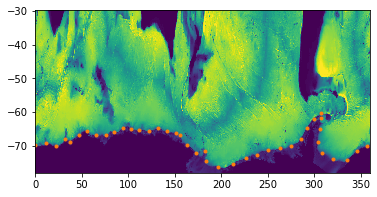

In [70]:
fig,ax = plt.subplots(figsize=(6,3))
ax.pcolormesh(ds['XC'],ds['YC'],ds['Depth'], shading='auto')
ax.plot(initlon,initlat,marker='.',linestyle=' ',color='tab:orange')

In [71]:
# If you want to get evenly spaced points starting from the start point:
istart = minpointnow
cumdistanceadj = cumdistance-cumdistance[istart]
minima, = argrelextrema(cumdistanceadj[istart:]%separation,np.less)
minima = np.append(istart,minima)+istart
# Get the lat and lon of points along contour
initlon = vnow[minima,0]
initlat = vnow[minima,1]

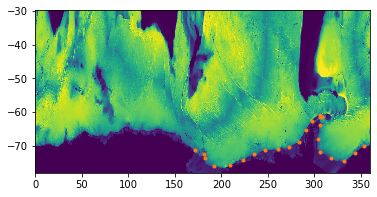

In [72]:
fig,ax = plt.subplots(figsize=(6,3))
ax.pcolormesh(ds['XC'],ds['YC'],ds['Depth'], shading='auto')
ax.plot(initlon,initlat,marker='.',linestyle=' ',color='tab:orange')

In [73]:
# If you want to get evenly spaced points starting from the start point
# and ending after a maximum distance along the contour:
istart = minpointnow
cumdistanceadj = cumdistance-cumdistance[istart]
minima, = argrelextrema(cumdistanceadj[istart:]%separation,np.less)
minima = np.append(istart,minima)+istart
# Max distance along contour from starting point
maxdistance = 5000 # (in km)
maxind = np.argmin(np.abs(cumdistanceadj-maxdistance))
minima = minima[minima<maxind]
# Get the lat and lon of points along contour
initlon = vnow[minima,0]
initlat = vnow[minima,1]

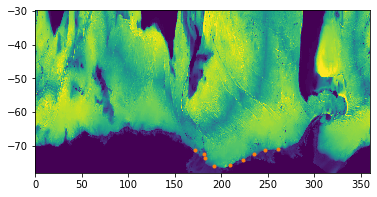

In [74]:
fig,ax = plt.subplots(figsize=(6,3))
ax.pcolormesh(ds['XC'],ds['YC'],ds['Depth'], shading='auto')
ax.plot(initlon,initlat,marker='.',linestyle=' ',color='tab:orange')